In [129]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
train_data_path = '../data/train_data.csv'
test_data_path = '../data/test_data.csv'

In [163]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Индексация фраз

In [4]:
train_data.shape

(441099, 3)

Для удобной работы закодируем уникальные фразы

In [5]:
dictionary = {}
for col in ['name_1', 'name_2']:
    for phraze in set(train_data[col]):
        if dictionary.get(phraze) is None:
            dictionary[phraze] = len(dictionary.keys())
dictionary_out = {v: k for k,v in dictionary.items()}

temp_dict = {'id': [], 'phraze': []}
for ph, ph_id in dictionary.items():
    temp_dict['id'].append(ph_id)
    temp_dict['phraze'].append(ph)
phrazes_ids = pd.DataFrame(temp_dict)

In [6]:
phrazes_ids.head(3)

,id,phraze
0,0,Vins Vignobles Llc
1,1,Selati Sp A
2,2,Kiran Shoes Manufacturers


In [7]:
phrazes_ids.shape

(17571, 2)

In [185]:
# phrazes_ids.to_csv('train_phraze_id_train.csv', index=False)

Можно знаметить, что уникальных гораздо меньше, чем уникальных пар.

Попробуем сформировать "граф" из фраз, где ребро между фразами будет формироваться в случае, если фразы описывают одну и ту же компанию.

In [83]:
def get_phraze_mask(df: pd.DataFrame, phraze: str,
                    cols: list = ['name_1', 'name_2']) -> pd.DataFrame:
    mask = df[cols[0]] == phraze
    for col in cols[1:]:
        mask += df[col] == phraze
    return mask

In [63]:
def get_class(df, mask) -> set:
    unique = set()
    ph_cols = ['name_1', 'name_2']
    for ph_c in ph_cols:
        unique.update(set(df[mask][df[mask]['is_duplicate'] == 1][ph_c]))
    return unique

In [122]:
def get_class_phrazes(df, phraze):
    class_phrazes = set()
    new_phrazes = {phraze}
    while new_phrazes:
        new_phrazes_t = set()
        for ph in new_phrazes:
            mask = get_phraze_mask(df, ph)
            new_phrazes_t.update(get_class(df, mask))
            class_phrazes.add(ph)
        new_phrazes_t -= class_phrazes
        new_phrazes = new_phrazes_t
    return class_phrazes

In [123]:
def collect_classes(phrazes_ids_df, main_data) -> pd.DataFrame:
    class_counter = 0
    class_dict = {'class': [], 'phraze': []}
    for phraze in tqdm(phrazes_ids_df['phraze']):
        if phraze not in class_dict['phraze']:
            mask = get_phraze_mask(main_data, phraze)
            class_i = get_class_phrazes(main_data, phraze)
            s = len(class_i)
            class_dict['phraze'].extend(class_i)
            class_dict['class'].extend([class_counter]*s)
            class_counter += 1
    return pd.DataFrame(class_dict)

In [126]:
phraze_classes = collect_classes(phrazes_ids, train_data)

  0%|          | 0/17571 [00:00<?, ?it/s]

In [127]:
print(phrazes_ids.shape)
print(phraze_classes.shape)

(17571, 2)
(17571, 2)


In [160]:
# phraze_classes.to_csv('phraze_classes.csv', index=False)

In [128]:
# число классов
phraze_classes.groupby('class').count().shape

(16829, 1)

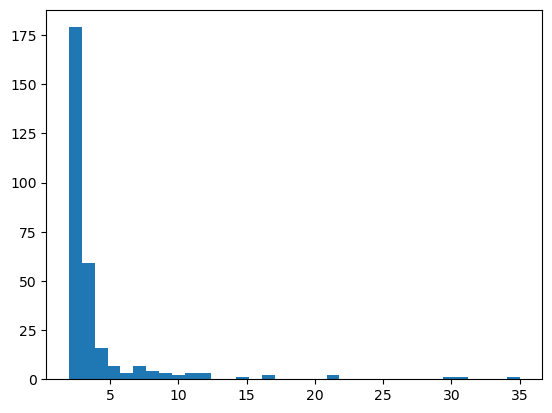

In [158]:
# распределение количества наблюдений в классах
grouped_count = phraze_classes.groupby('class').count()

_ = plt.hist(grouped_count[grouped_count['phraze'] != 1]['phraze'],
         bins=grouped_count[grouped_count['phraze'] != 1]['phraze'].max())

In [212]:
full_data = pd.concat([train_data, test_data])
full_data.shape

(490111, 3)

In [213]:
dictionary = {}
for col in ['name_1', 'name_2']:
    for phraze in set(full_data[col]):
        if dictionary.get(phraze) is None:
            dictionary[phraze] = len(dictionary.keys())
dictionary_out = {v: k for k,v in dictionary.items()}

temp_dict = {'id': [], 'phraze': []}
for ph, ph_id in dictionary.items():
    temp_dict['id'].append(ph_id)
    temp_dict['phraze'].append(ph)
full_data_phrazes_ids = pd.DataFrame(temp_dict)

In [222]:
full_data_phrazes_ids.to_csv('phraze_id_full.csv', index=False)

In [215]:
full_data_phraze_classes = collect_classes(
    full_data_phrazes_ids, full_data)

  0%|          | 0/17604 [00:00<?, ?it/s]

In [216]:
print(full_data_phrazes_ids.shape)
print(full_data_phraze_classes.shape)

(17604, 2)
(17604, 2)


In [217]:
full_data_phraze_classes.head(3)

,class,phraze
0,0,Vins Vignobles Llc
1,1,Selati Sp A
2,2,Kiran Shoes Manufacturers


In [218]:
full_data_phraze_classes.groupby('class').count().shape

(16824, 1)

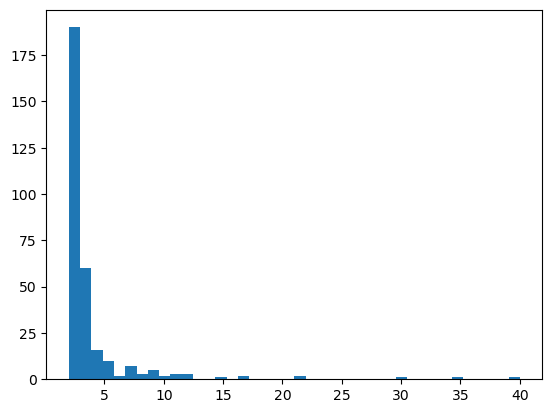

In [219]:
# распределение количества наблюдений в классах
grouped_count_full = full_data_phraze_classes.groupby('class').count()

_ = plt.hist(grouped_count_full[grouped_count_full['phraze'] != 1]['phraze'],
         bins=grouped_count_full[grouped_count_full['phraze'] != 1]['phraze'].max())

In [221]:
# full_data_phraze_classes.to_csv('phraze_classes_full.csv', index=False)

**Test data**

In [223]:
test_data_prhazes = set(test_data['name_1'])
test_data_prhazes.update(set(test_data['name_2']))
test_data_prhazes_s = pd.Series(list(test_data_prhazes))

In [224]:
test_data_prhazes_s.shape

(15436,)

In [227]:
full_data_phraze_classes.index = full_data_phraze_classes['phraze']

In [228]:
full_data_phraze_classes.head(3)

,class,phraze
phraze,,
Vins Vignobles Llc,0,Vins Vignobles Llc
Selati Sp A,1,Selati Sp A
Kiran Shoes Manufacturers,2,Kiran Shoes Manufacturers


In [235]:
test_data_phraze_classes = full_data_phraze_classes.loc[test_data_prhazes_s].copy()
test_data_phraze_classes = test_data_phraze_classes.reset_index(drop=True)
print(test_data_phraze_classes.shape)

(15436, 2)


In [236]:
test_data_phraze_classes.head(3)

,class,phraze
0,1,Selati Sp A
1,3,Vikas Multicorp Ltd
2,8,K Tex Llc


In [237]:
# test_data_phraze_classes.to_csv('phraze_classes_test.csv', index=False)

In [242]:
test_data_phraze_ids = pd.DataFrame(
    {'id': range(test_data_phraze_classes.shape[0]),
     'phraze': test_data_phraze_classes['phraze']}
)

In [244]:
print(test_data_phraze_ids.shape)
test_data_phraze_ids.head(3)

(15436, 2)


,id,phraze
0,0,Selati Sp A
1,1,Vikas Multicorp Ltd
2,2,K Tex Llc


In [245]:
# test_data_phraze_ids.to_csv('phraze_id_test.csv', index=False)